# Implementation of Anomaly detection using Autoencoders
Dataset used here is Credit Card Fraud Detection from Kaggle.

### Import required libraries

In [1]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [2]:
try:
    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)
except Exception as e:
    print(e)
    print("Not possible to set gpu allow growth")

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,normalize, MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

from keras import backend as K
print("-------------------------------------------")
print("GPU available: ", tf.test.is_gpu_available())
print("Keras backend: ", K.backend())
print("-------------------------------------------")

# Load layers from keras
from keras.layers import Dense, Input, Concatenate, Flatten, BatchNormalization, Dropout, LeakyReLU
from keras.models import Sequential, Model
from keras.losses import binary_crossentropy
from Disco_tensor_flow import distance_corr
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
RANDOM_SEED = 2021 
TEST_PCT = 0.3
LABELS = ["Normal","Anomaly"]

-------------------------------------------
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available:  False
Keras backend:  tensorflow
-------------------------------------------


In [4]:
# define new loss with distance decorrelation
def decorr(var_1, var_2, weights,kappa):

    def loss(y_true, y_pred):
        #return binary_crossentropy(y_true, y_pred) + distance_corr(var_1, var_2, weights)
        #return distance_corr(var_1, var_2, weights)
        return binary_crossentropy(y_true, y_pred) + kappa * distance_corr(var_1, var_2, weights,power=2)
        #return binary_crossentropy(y_true, y_pred)

    return loss

### Read the dataset

In [5]:
##########################################################
# ------------------------------------------------------ #
# ----------------------- LOADING ---------------------- #
# ------------------------------------------------------ #
##########################################################
# Firstly the model loads the background and signal data, 
# then it removes the attributes first string line, which 
# are the column names, in order to avoid NaN values in 
# the array.

print('         ==== Commencing Initiation ====\n')

### Background
b_name='/home/thiago/Documents/Data_Sets/LPC-anomaly-detection/Input_Background_1.csv'
background = np.genfromtxt(b_name, delimiter=',')
background = background[1:,:]
print("     .Background Loaded..." )
print("     .Background shape: {}".format(background.shape))

### Signal
s_name='/home/thiago/Documents/Data_Sets/LPC-anomaly-detection/Input_Signal_1.csv'
signal = np.genfromtxt(s_name, delimiter=',')
signal = signal[1:,:]
print("     .Signal Loaded...")
print("     .Signal shape: {}\n".format(signal.shape))

         ==== Commencing Initiation ====

     .Background Loaded...
     .Background shape: (543500, 21)
     .Signal Loaded...
     .Signal shape: (522467, 21)



### Selecting the most pertinent attributes

pertinent_features = [2,3,4,6,10,11,12,14,15,16,18,19,20]

background = background[:,pertinent_features]
signal = signal[:,pertinent_features]

In [6]:
##########################################################
# ------------------------------------------------------ #
# --------------------- INITIATION --------------------- #
# ------------------------------------------------------ #
##########################################################

# Number of events
total = 100000

# Percentage of background samples on the testing phase
background_percent = 0.99

# Percentage of samples on the training phase
test_size = 0.3

In [7]:
print('\n          ==== Initiation Complete ====\n')
print('=*='*17 )
print('      ==== Commencing Data Processing ====')

# Percentage of background samples to divide the data-set
dat_set_percent = total/len(background)

# Reducing background samples
_,reduced_background = train_test_split(background, test_size=dat_set_percent)

# Iserting the correct number of signal in streaming

n_signal_samples = int(len(reduced_background)*(1-background_percent))

_,reduced_background = train_test_split(reduced_background, test_size=background_percent)

_,reduced_signal = train_test_split(signal, test_size=n_signal_samples/len(signal))

# Concatenating Signal and the Background sub-sets

data = np.vstack((reduced_background,reduced_signal))

# Normalize Data
print('.Normalizing Data')
data = normalize(data,norm='max',axis=0)

print(".formatted data shape: {}".format(data.shape))
print(".Background shape: {}".format(reduced_background.shape))
print(".Signal shape: {}".format(reduced_signal.shape))

# Creating Labels
print('.Creating Labels')

labels =np.ones((len(data)))
labels[:len(reduced_background)] = 0


          ==== Initiation Complete ====

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
      ==== Commencing Data Processing ====
.Normalizing Data
.formatted data shape: (100000, 21)
.Background shape: (99000, 21)
.Signal shape: (1000, 21)
.Creating Labels


In [8]:
attributes = np.array(["px1","py1","pz1","E1","eta1","phi1","pt1","px2","py2","pz2","E2","eta2",
            "phi2","pt2","Delta_R","M12","MET","S","C","HT","A","Class"])

dataset = pd.DataFrame(np.hstack((data,labels.reshape(-1,1))),columns = attributes)

# Exploratory Data Analysis

In [9]:
dataset.head()

,px1,py1,pz1,E1,eta1,phi1,pt1,px2,py2,pz2,...,phi2,pt2,Delta_R,M12,MET,S,C,HT,A,Class
0,0.178826,0.121040,-0.016243,0.058227,-0.077133,0.191365,0.191971,-0.171495,-0.044606,0.117730,...,-0.919192,0.160281,0.486589,0.126564,0.023759,0.235098,0.610884,0.175482,0.093127,0.0
1,-0.090764,0.176018,-0.137700,0.147010,-0.458244,0.649850,0.177169,0.043767,-0.161020,0.026110,...,-0.415330,0.150617,0.537779,0.138595,0.037265,0.086177,0.483574,0.166633,0.053617,0.0
2,0.194971,0.064432,-0.132835,0.142747,-0.442528,0.102858,0.182026,-0.164307,-0.040303,-0.111623,...,-0.923613,0.153026,0.448671,0.085152,0.022017,0.277148,0.391973,0.166780,0.005721,0.0
3,-0.172336,-0.053578,0.311204,0.314360,0.696048,-0.902874,0.159959,0.161330,0.036672,0.035189,...,0.070982,0.149652,0.532620,0.122208,0.039876,0.042348,0.244379,0.158371,-0.003553,0.0
4,-0.192211,0.002987,0.286292,0.290196,0.657692,0.995008,0.170183,0.182024,-0.021109,0.331345,...,-0.036664,0.165766,0.445699,0.085504,0.018409,0.057281,0.169115,0.166321,-0.000275,0.0


In [10]:
#check for any  nullvalues 
print("Any nulls in the dataset ",dataset.isnull().values.any() )
print('-------')
print("No. of unique labels ", len(dataset['Class'].unique()))
print("Label values ",dataset.Class.unique())
#0 is for normal credit card transaction
#1 is for fraudulent credit card transaction
print('-------')
print("Break down of the Normal and Fraud Transactions")
print(pd.value_counts(dataset['Class'], sort = True) )

Any nulls in the dataset  False
-------
No. of unique labels  2
Label values  [0. 1.]
-------
Break down of the Normal and Fraud Transactions
0.0    99000
1.0     1000
Name: Class, dtype: int64


### Visualize the dataset
plotting the number of normal and fraud transactions in the dataset.

In [11]:
#Visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

### Create train and test dataset
Checking on the dataset

The last column in the dataset is our target variable.

In [12]:
def probability(df):
    mu = np.mean(df, axis=0)
    variance = np.mean((df - mu)**2, axis=0)
    var_dia = np.diag(variance)
    k = len(mu)
    X = df - mu
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(var_dia)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(var_dia) * X,axis=1))
    return p

In [13]:
raw_data = dataset.values
# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.3, random_state=2021 ,stratify = labels)

p_train = probability(train_data)
p_test = probability(test_data)

> Use only normal transactions to train the Autoencoder.

Normal data has a value of 0 in the target variable. Using the target variable to create a normal and fraud dataset.

In [14]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
#creating normal and fraud datasets
normal_train_data = train_data[~train_labels]
normal_p_train = p_train[~train_labels]

normal_test_data = test_data[~test_labels]
normal_p_test = p_test[~test_labels]

#fraud_train_data = train_data[train_labels]
#fraud_p_train = p_train[train_labels]

fraud_test_data = test_data[test_labels]
fraud_p_test = p_test[test_labels]
print(" No. of records in Fraud Train Data=",len(fraud_train_data))
print(" No. of records in Normal Train data=",len(normal_train_data))
print(" No. of records in Fraud Test Data=",len(fraud_test_data))
print(" No. of records in Normal Test data=",len(normal_test_data))

NameError: name 'fraud_train_data' is not defined

### Set the training parameter values

### Create the Autoencoder
The architecture of the autoencoder is shown below.

![esquema](autoencoder.png)

In [15]:
nb_epoch = 10
batch_size = 100
input_dim = normal_train_data.shape[1]
encoding_dim = 2
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=1
learning_rate = 0.001

In [16]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",                                
activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 44        
_________________________________________________________________
dropout (Dropout)            (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1)                 0     

### Define the callbacks for checkpoints and early stopping

In [17]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               mode='min', monitor='val_loss', verbose=2, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

### Compile the Autoencoder

In [18]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

### Train the Autoencoder

In [19]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_data, test_data),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Train on 69300 samples, validate on 30000 samples
Epoch 1/10
68600/69300 [============================>.] - ETA: 0s - loss: 0.0540 - accuracy: 0.2909

/home/thiago/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.03615, saving model to autoencoder_fraud.h5
69300/69300 [==============================] - 14s 204us/sample - loss: 0.0539 - accuracy: 0.2914 - val_loss: 0.0361 - val_accuracy: 0.3416
Epoch 2/10
68900/69300 [============================>.] - ETA: 0s - loss: 0.0420 - accuracy: 0.3299
Epoch 00002: val_loss improved from 0.03615 to 0.03539, saving model to autoencoder_fraud.h5
69300/69300 [==============================] - 10s 149us/sample - loss: 0.0420 - accuracy: 0.3302 - val_loss: 0.0354 - val_accuracy: 0.3416
Epoch 3/10
68700/69300 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.3370
Epoch 00003: val_loss did not improve from 0.03539
69300/69300 [==============================] - 10s 139us/sample - loss: 0.0418 - accuracy: 0.3367 - val_loss: 0.0356 - val_accuracy: 0.3416
Epoch 4/10
69200/69300 [============================>.] - ETA: 0s - loss: 0.0414 - accuracy: 0.3403
Epoch 00004: val_loss did not improve from 0.0

Plot training and test loss

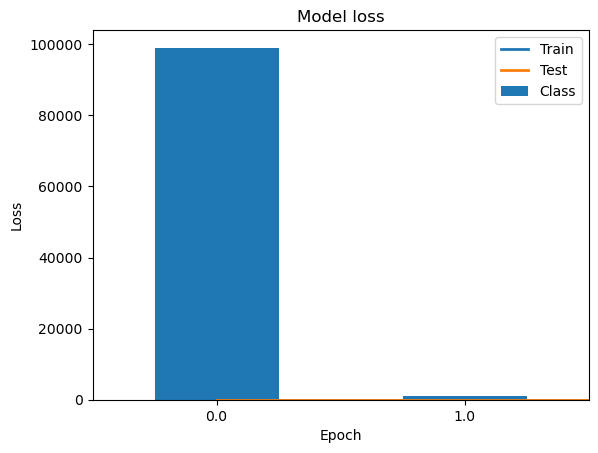

In [20]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

# Detect Anomalies on test data
> Anomalies are data points where the reconstruction loss is higher

To calculate the reconstruction loss on test data, predict the test data and calculate the mean square error between the test data and the reconstructed test data.

In [21]:
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})

Plotting the test data points and their respective reconstruction error sets a threshold value to visualize if the threshold value needs to be adjusted.

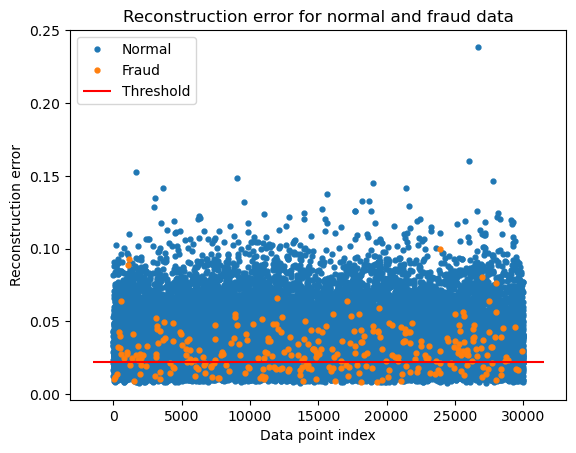

In [22]:
threshold_fixed = 0.022
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

Detect anomalies as points where the reconstruction loss is greater than a fixed threshold. Here we see that a value of 52 for the threshold will be good.
### Evaluating the performance of the anomaly detection

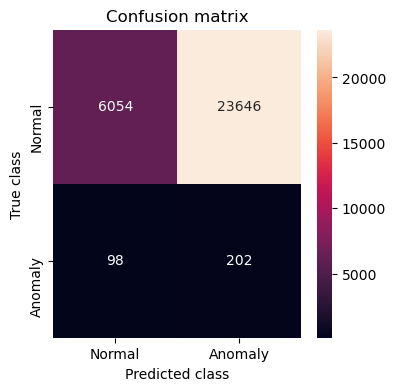

 Accuracy:  0.20853333333333332
 Recall:  0.6733333333333333
 Precision:  0.008470311975847031


In [23]:
threshold_fixed =0.022
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

As our dataset is highly imbalanced, we see a high accuracy but a low recall and precision.
Things to further improve precision and recall would add more relevant features, different architecture for autoencoder, different hyperparameters, or a different algorithm.
# Conclusion:
Autoencoder can be used as an anomaly detection algorithm when we have an unbalanced dataset where we have a lot of good examples and only a few anomalies. Autoencoders are trained to minimize reconstruction error. When we train the autoencoders on normal data or good data, we can hypothesize that the anomalies will have higher reconstruction errors than the good or normal data.

In [79]:
nb_epoch = 10
batch_size = 500
input_dim = normal_train_data.shape[1]
encoding_dim = 8
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2 = 2
learning_rate = 0.001

In [80]:
#input Layer
input_layer = Input(shape=(input_dim, ))
sample_weights = Input(shape=(1, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="sigmoid",                                
activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=[input_layer, sample_weights], outputs=decoder)
autoencoder.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 8)            176         input_18[0][0]                   
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 8)            0           dense_54[0][0]                   
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 4)            36          dropout_18[0][0]                 
____________________________________________________________________________________________

In [81]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               mode='min', monitor='val_loss', verbose=2, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

In [82]:
opt = Adam(lr=0.001)
autoencoder.compile(optimizer=opt, loss=decorr(input_layer[:,15], decoder[:,15], sample_weights[:,0],100))

In [83]:
Train = [normal_train_data, np.ones(len(normal_train_data))]

history = autoencoder.fit(x = Train, y = normal_train_data,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Train on 62370 samples, validate on 6930 samples
Epoch 1/10
62370/62370 [==============================] - ETA: 0s - loss: 0.6688

/home/thiago/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss did not improve from inf
62370/62370 [==============================] - 13s 212us/sample - loss: 0.6688 - val_loss: nan
Epoch 2/10
62000/62370 [============================>.] - ETA: 0s - loss: 0.5648
Epoch 00002: val_loss improved from inf to 0.48613, saving model to autoencoder_fraud.h5
62370/62370 [==============================] - 8s 135us/sample - loss: 0.5643 - val_loss: 0.4861
Epoch 3/10
62370/62370 [==============================] - ETA: 0s - loss: 0.3504
Epoch 00003: val_loss improved from 0.48613 to 0.27282, saving model to autoencoder_fraud.h5
62370/62370 [==============================] - 7s 112us/sample - loss: 0.3504 - val_loss: 0.2728
Epoch 4/10
62000/62370 [============================>.] - ETA: 0s - loss: 0.2500
Epoch 00004: val_loss improved from 0.27282 to 0.22565, saving model to autoencoder_fraud.h5
62370/62370 [==============================] - 7s 119us/sample - loss: 0.2501 - val_loss: 0.2256
Epoch 5/10
62370/62370 [========================

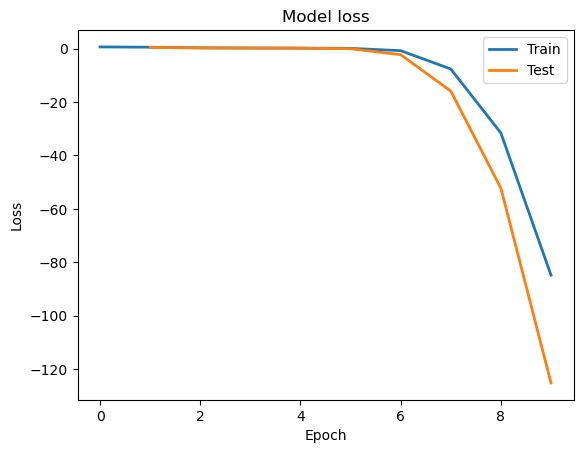

In [84]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [85]:
test_x_predictions = autoencoder.predict([test_data,np.ones(len(test_data))])
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})

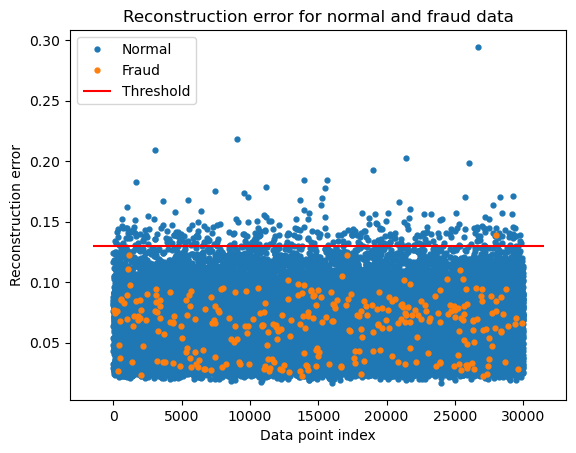

In [86]:
threshold_fixed = 0.13
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

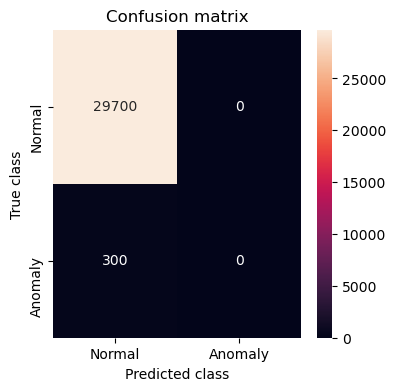

 Accuracy:  0.99
 Recall:  0.0
 Precision:  0.0


/home/thiago/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
threshold_fixed =0.13
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))
